In [2]:
import leaf_audio.frontend as frontend

2024-12-06 19:44:09.338693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np

In [3]:
train_dss = tfds.load('speech_commands',data_dir="../tensorflow_datasets", split='train', shuffle_files=True)
val_dss = tfds.load('speech_commands',data_dir="../tensorflow_datasets", split='validation', shuffle_files=True)
test_dss = tfds.load('speech_commands',data_dir="../tensorflow_datasets", split='test', shuffle_files=True)

counting finished
[   0.    0.    0. ...    0.    0. 9068.]
[ 377.  372.  352.  406.  373.  363.  363.  350.  350.  397.  121. 6278.]
counting finished
[   0.    0.    0. ...    0.    0. 4890.]
[406. 402. 412. 405. 402. 396. 396. 411. 425. 419. 408. 408.]
counting finished
[    0.     0.     0. ...     0.     0. 77032.]
[ 3134.  3106.  3037.  3130.  2970.  3086.  3019.  3111.  2948.  3228.
   668. 54074.]


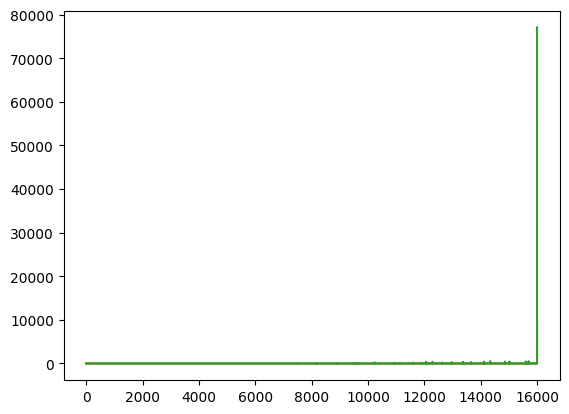

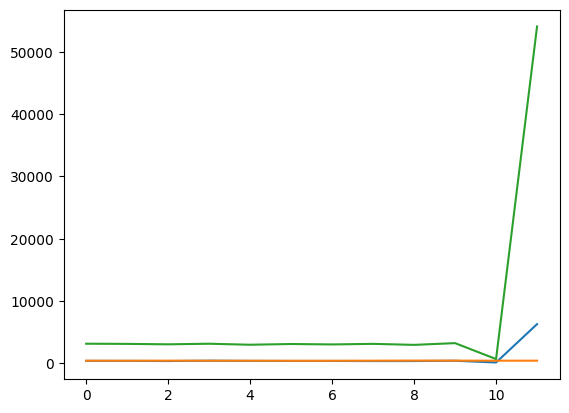

In [82]:
# count label numbers in three datasets
info_count_val = {'length':np.zeros([16001]),'label_count':np.zeros([12])}
info_count_train = {'length':np.zeros([16001]),'label_count':np.zeros([12])}
info_count_test = {'length':np.zeros([16001]),'label_count':np.zeros([12])}
# preprocess the dataset
def count_dataset(ds,info):
    def preprocess_fn(data):
        audio = data['audio']
        label = data['label']
        audio_length = tf.shape(audio)[0]
        return audio_length,label

    ds_map=ds.map(preprocess_fn,-1).batch(256)
    for audio_length,label in ds_map:
        for length in audio_length.numpy():
            info['length'][length] += 1
        info['label_count'] += tf.one_hot(label,12,dtype=tf.float32).numpy().sum(axis=0)
    print('counting finished')
    print(info['length'])
    print(info['label_count'])


val_ds = count_dataset(val_dss,info_count_val)
test_ds = count_dataset(test_dss,info_count_test)
train_ds = count_dataset(train_dss,info_count_train)

# plot the distribution of audio length
import matplotlib.pyplot as plt
plt.plot(info_count_val['length'])
plt.plot(info_count_test['length'])
plt.plot(info_count_train['length'])
plt.show()

# plot the distribution of label
plt.plot(info_count_val['label_count'])
plt.plot(info_count_test['label_count'])
plt.plot(info_count_train['label_count'])
plt.show()







In [ ]:
# preprocess the dataset
def preprocess_dataset(ds):
    def preprocess_fn(data):
        audio = data['audio']
        label = data['label']
        audio = tf.pad(audio, paddings=[[0, 16000-tf.shape(audio)[0]]], mode='CONSTANT')
        audio = tf.cast(audio, tf.float32)/32768.0
        return audio, label
    return ds.map(preprocess_fn,-1)

train_ds = preprocess_dataset(train_dss)
val_ds = preprocess_dataset(val_dss)
test_ds = preprocess_dataset(test_dss)


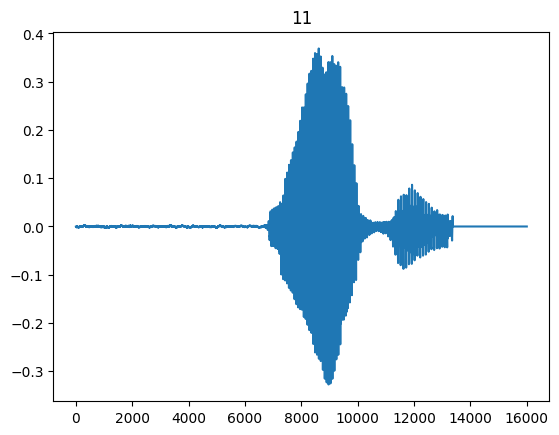

In [6]:
# plot the audio sample
import matplotlib.pyplot as plt
audio, label = next(iter(train_ds))
plt.plot(audio.numpy())
plt.title(label.numpy())
plt.show()

# play the audio with librosa
import librosa
import IPython.display as ipd
ipd.Audio(audio.numpy(), rate=16000)


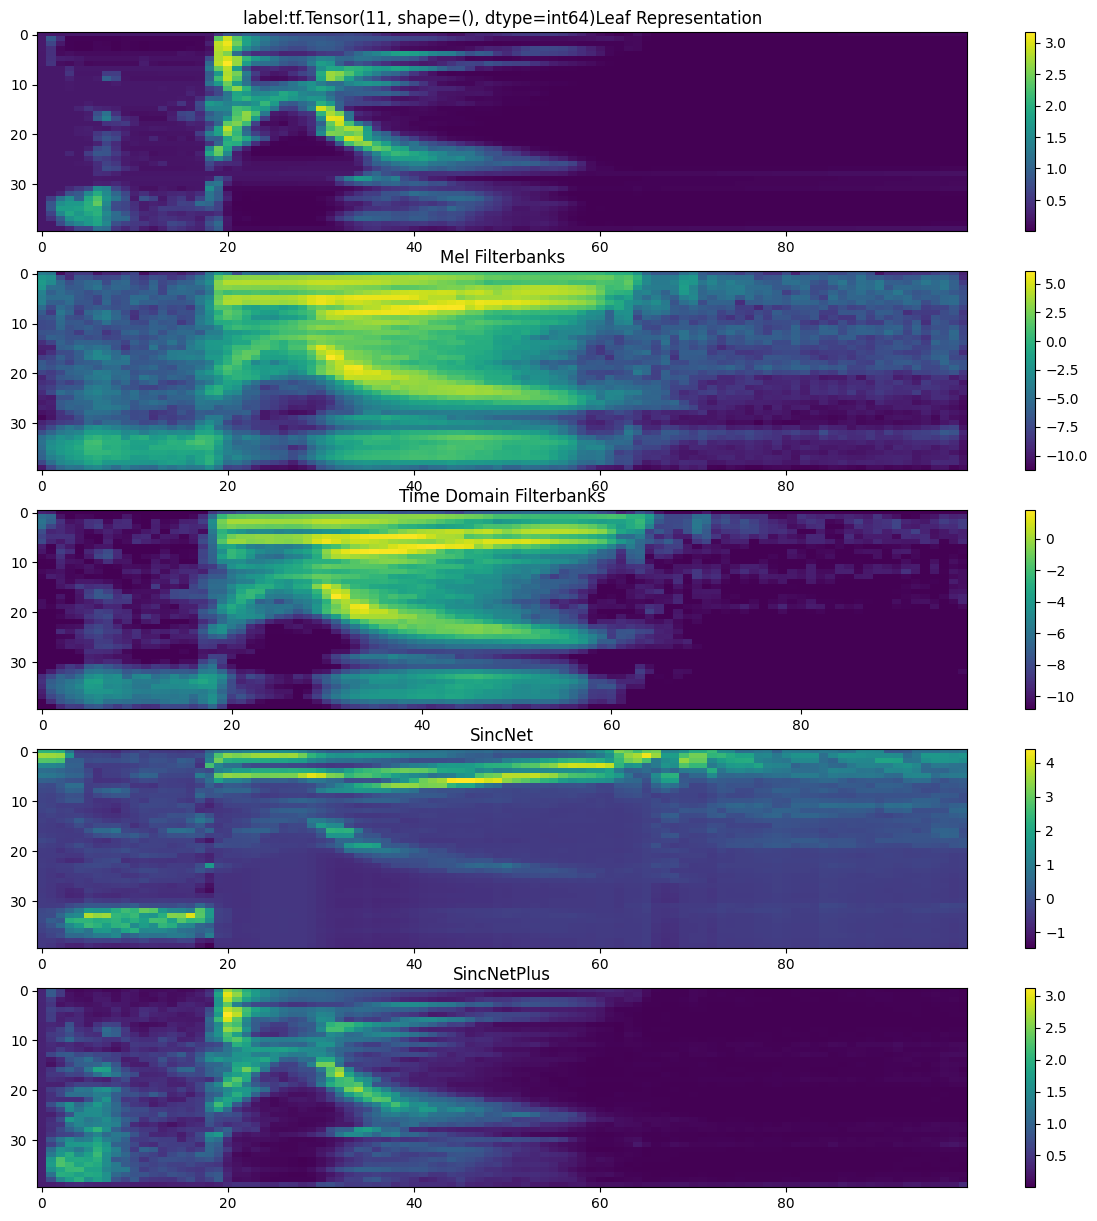

In [51]:
# plot the spectrogram
audio_sample,audio_sample_label = next(iter(train_ds))
audio_sample = tf.reshape(audio_sample, [1, -1])
leaf = frontend.Leaf()
melfbanks = frontend.MelFilterbanks()
tfbanks = frontend.TimeDomainFilterbanks()
sincnet = frontend.SincNet()
sincnet_plus = frontend.SincNetPlus()

leaf_representation = leaf(audio_sample)
melfbanks_representation = melfbanks(audio_sample)
tfbanks_representation = tfbanks(audio_sample)
sincnet_representation = sincnet(audio_sample)
sincnet_plus_representation = sincnet_plus(audio_sample)

# plot the spectrogram
plt.figure(figsize=(15, 15))
plt.subplot(511)
plt.imshow(leaf_representation[0].numpy().T, aspect='auto')
plt.title('label:'+str(audio_sample_label)+'Leaf Representation')
plt.colorbar()
plt.subplot(512)
plt.imshow(melfbanks_representation[0].numpy().T, aspect='auto')
plt.title('Mel Filterbanks')
plt.colorbar()
plt.subplot(513)
plt.imshow(tfbanks_representation[0].numpy().T, aspect='auto')
plt.title('Time Domain Filterbanks')
plt.colorbar()
plt.subplot(514)
plt.imshow(sincnet_representation[0].numpy().T, aspect='auto')
plt.title('SincNet')
plt.colorbar()
plt.subplot(515)
plt.imshow(sincnet_plus_representation[0].numpy().T, aspect='auto')
plt.title('SincNetPlus')
plt.colorbar()


plt.show()

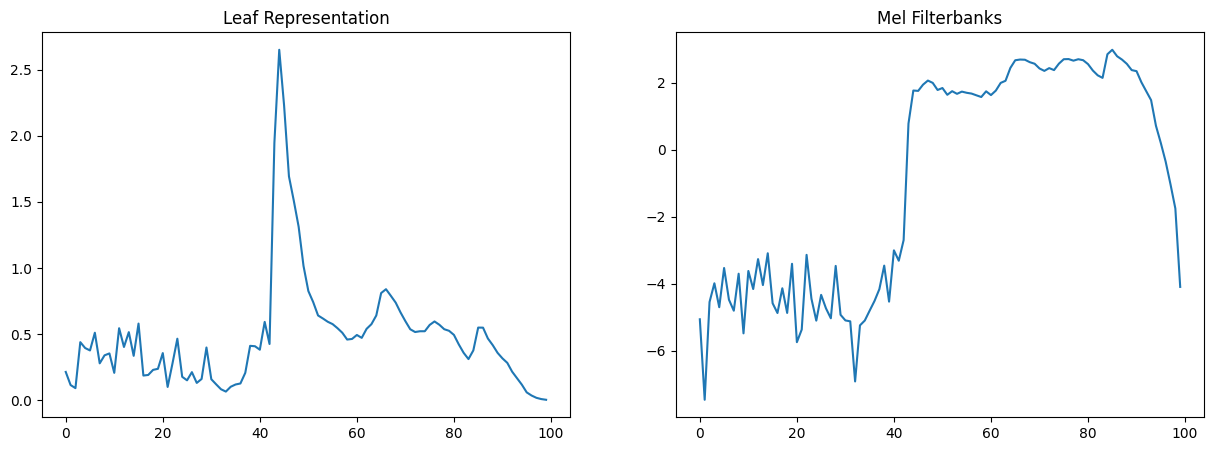

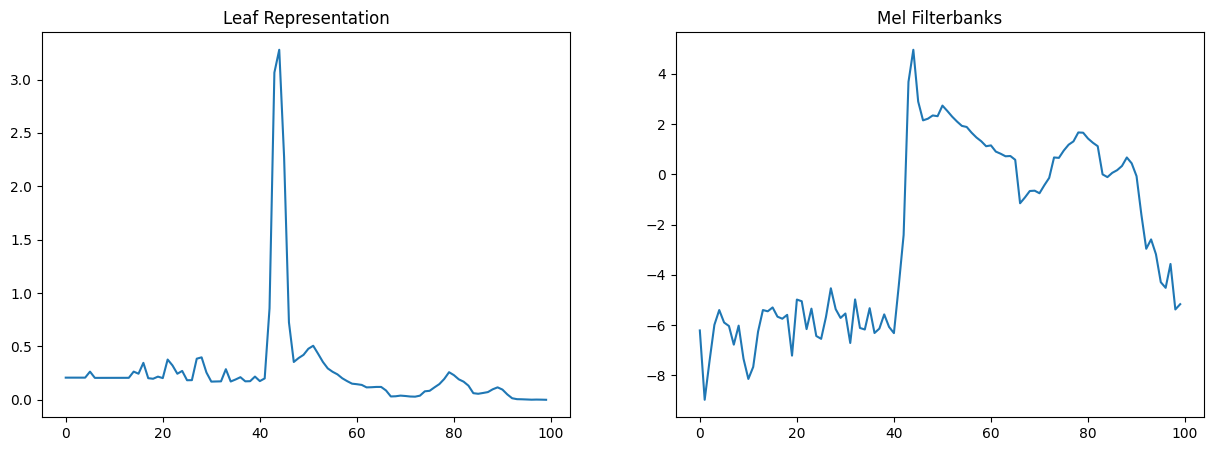

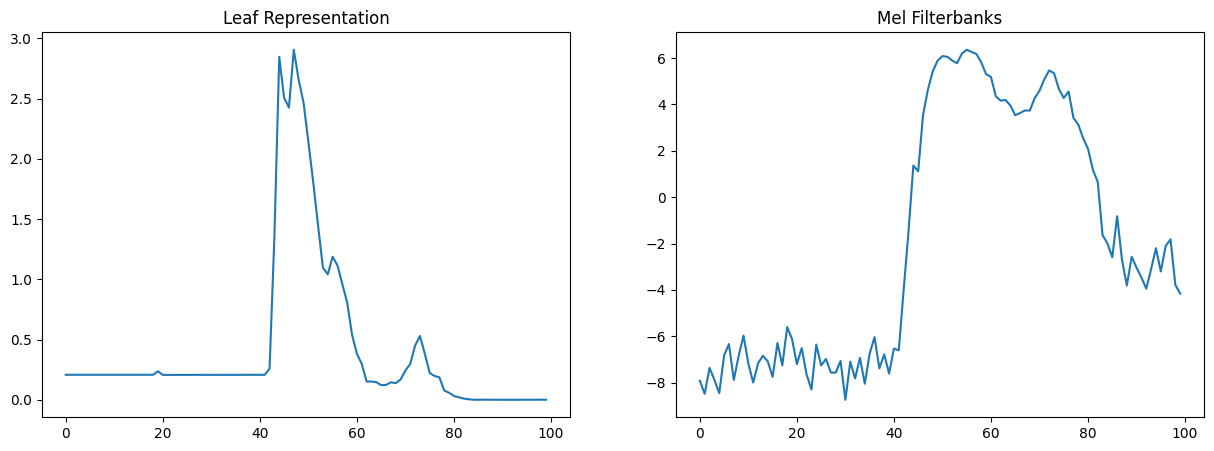

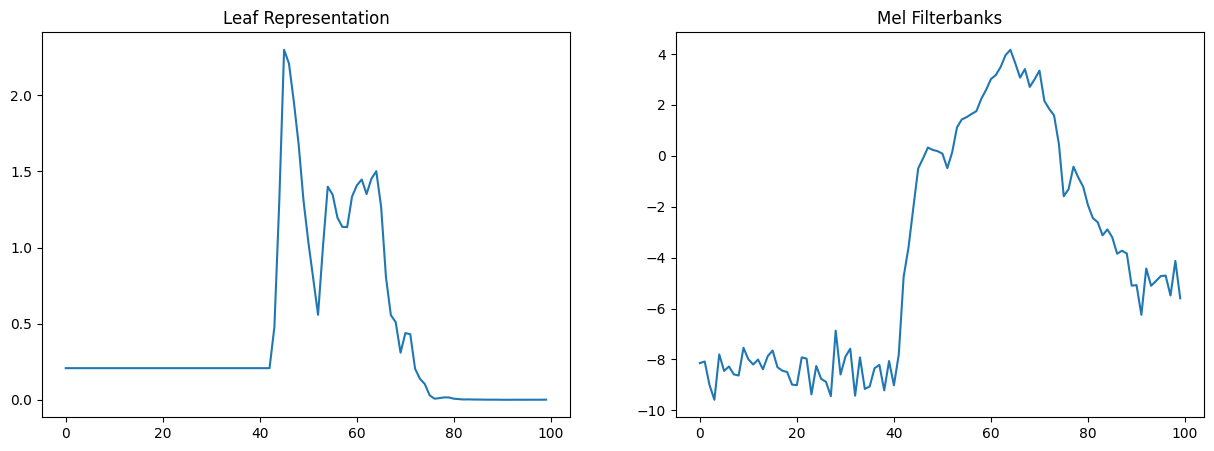

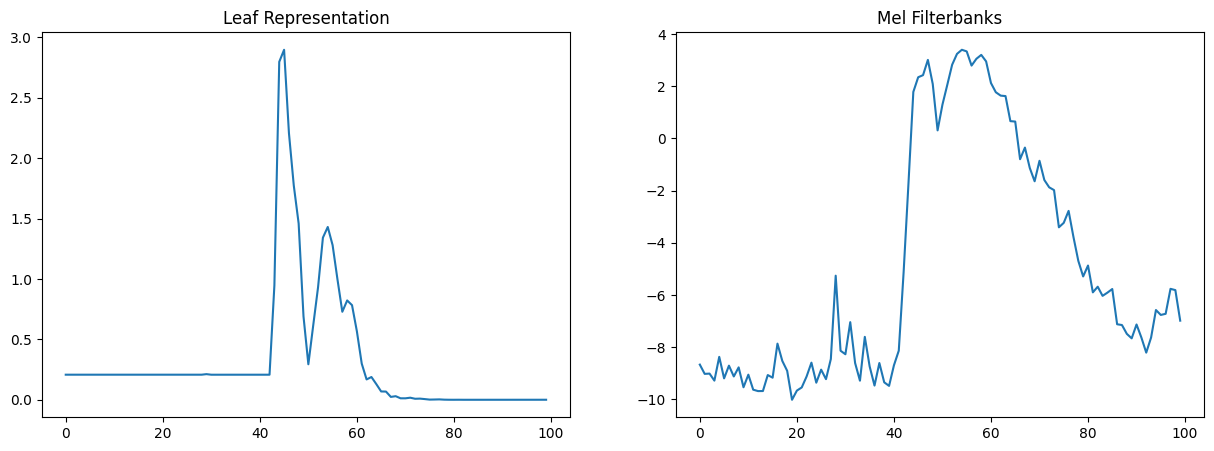

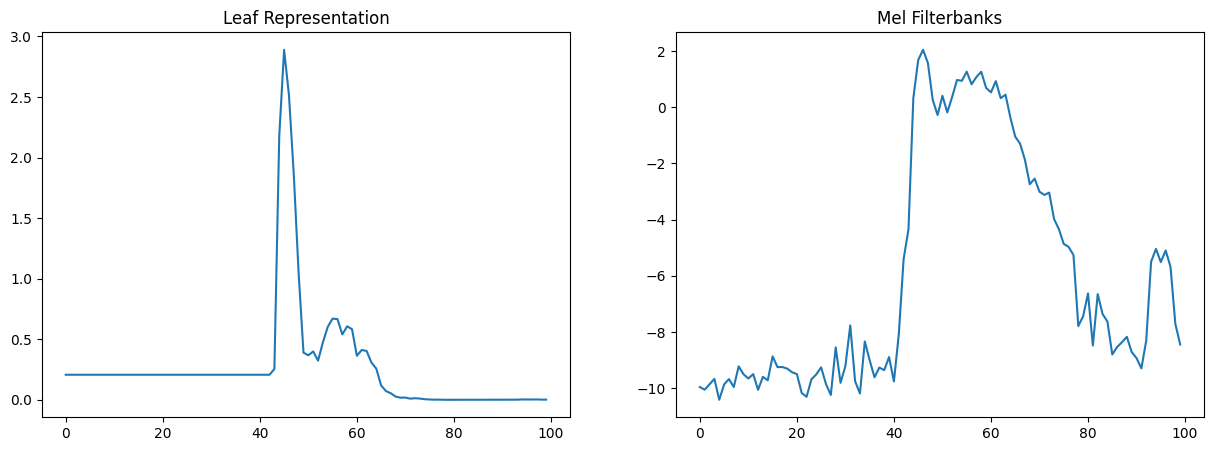

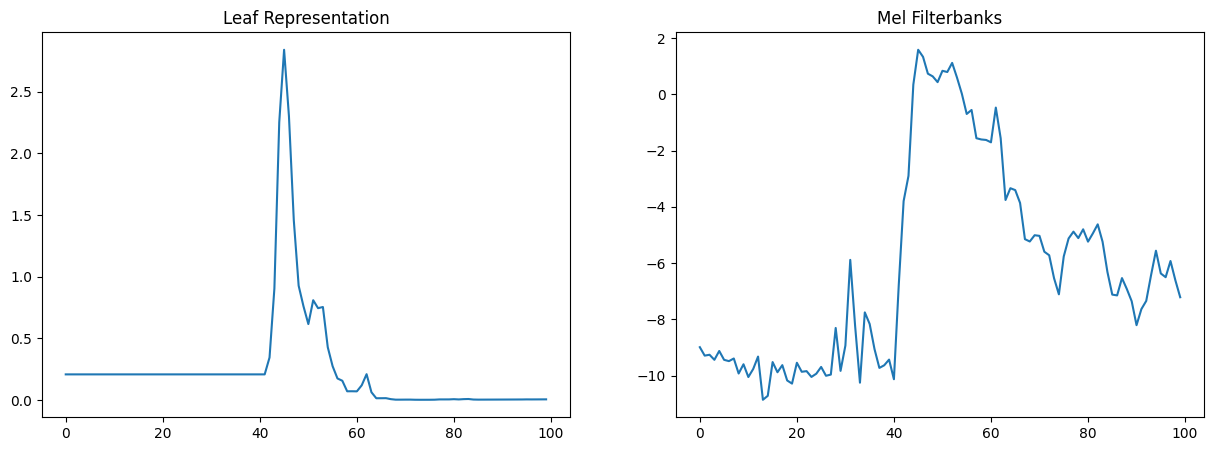

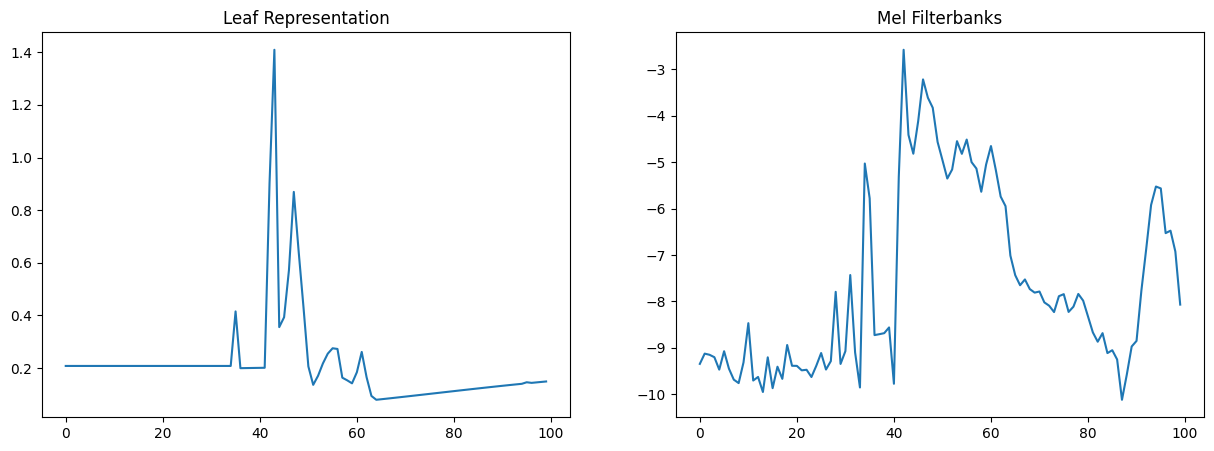

In [45]:
# plot frequency and amplitude 

for i in range(1,40,5):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(leaf_representation[0].numpy()[:,i])
    plt.title('Leaf Representation')
    plt.subplot(122)
    plt.plot(melfbanks_representation[0].numpy()[:,i])
    plt.title('Mel Filterbanks')
    plt.show()
